In [36]:
import pandas as pd
from pyspark.ml.regression import LinearRegression

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import month
from pyspark.sql.functions import countDistinct

import matplotlib.pyplot as plt

In [2]:
path = "Remas_Monzon_jun-sep.xlsx"
spark = SparkSession.builder.appName("Test").getOrCreate()

In [3]:
pdf = pd.read_excel(path, index_col=0)
# pdf = pdf.iloc[: , 1:]

In [4]:
df = spark.createDataFrame(pdf)

In [5]:
df.show()

+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+
|     Estacion|              Fecha|Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|
+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+
|CASA COLORADA|2021-06-01 00:00:00|      24.38|           44.38|          0.0|             991.19|               0.0|
|CASA COLORADA|2021-06-01 01:00:00|      23.05|           47.35|          0.0|             991.07|              0.02|
|CASA COLORADA|2021-06-01 02:00:00|       22.1|            50.8|          0.0|             991.15|               0.0|
|CASA COLORADA|2021-06-01 03:00:00|      21.52|           51.18|          0.0|             991.27|               0.0|
|CASA COLORADA|2021-06-01 04:00:00|      20.84|            53.2|          0.0|             991.17|               0.0|
|CASA COLORADA|2021-06-01 05:00:00|       20.1|         

In [6]:
df.cache()
df.printSchema()

root
 |-- Estacion: string (nullable = true)
 |-- Fecha: timestamp (nullable = true)
 |-- Temperatura: double (nullable = true)
 |-- Humedad_relativa: double (nullable = true)
 |-- Precipitacion: double (nullable = true)
 |-- Presion_barometrica: double (nullable = true)
 |-- Evapotranspiracion: double (nullable = true)



In [7]:
df.describe().show()

+-------+-------------------+------------------+----------------+-------------+-------------------+------------------+
|summary|           Estacion|       Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|
+-------+-------------------+------------------+----------------+-------------+-------------------+------------------+
|  count|             878457|            878457|          878457|       878457|             878457|            878457|
|   mean|               null|28.517840372380153|             NaN|          NaN|                NaN|               NaN|
| stddev|               null| 6.285929058607129|             NaN|          NaN|                NaN|               NaN|
|    min|BACERAC (LA MISION)|               4.7|            2.13|          0.0|                0.0|               0.0|
|    max|             YECORA|             48.06|             NaN|          NaN|                NaN|               NaN|
+-------+-------------------+------------------+

In [7]:
df.count()

878457

## Contando valores faltantes

In [8]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns if c != "Fecha"]).show()

+--------+-----------+----------------+-------------+-------------------+------------------+
|Estacion|Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|
+--------+-----------+----------------+-------------+-------------------+------------------+
|       0|          0|          114320|           72|               1161|             26239|
+--------+-----------+----------------+-------------+-------------------+------------------+



## Resolviendo los valores faltantes

In [10]:
drop_null = df.dropna(how ='any')
drop_null.show()

+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+
|     Estacion|              Fecha|Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|
+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+
|CASA COLORADA|2021-06-01 00:00:00|      24.38|           44.38|          0.0|             991.19|               0.0|
|CASA COLORADA|2021-06-01 01:00:00|      23.05|           47.35|          0.0|             991.07|              0.02|
|CASA COLORADA|2021-06-01 02:00:00|       22.1|            50.8|          0.0|             991.15|               0.0|
|CASA COLORADA|2021-06-01 03:00:00|      21.52|           51.18|          0.0|             991.27|               0.0|
|CASA COLORADA|2021-06-01 04:00:00|      20.84|            53.2|          0.0|             991.17|               0.0|
|CASA COLORADA|2021-06-01 05:00:00|       20.1|         

## Cantidad de datos antes y después de remover valores faltantes

In [23]:
# Antes
df.count()

878457

In [24]:
# Después
drop_null.count()

740185

In [25]:
# Ahora no hay ningún valor faltante
drop_null.select([count(when(isnan(c), c)).alias(c) for c in df.columns if c != "Fecha"]).show()

+--------+-----------+----------------+-------------+-------------------+------------------+
|Estacion|Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|
+--------+-----------+----------------+-------------+-------------------+------------------+
|       0|          0|               0|            0|                  0|                 0|
+--------+-----------+----------------+-------------+-------------------+------------------+



## Obteniendo una descripción de los datos

In [26]:
drop_null.describe().show()

+-------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|summary|           Estacion|       Temperatura|  Humedad_relativa|     Precipitacion|Presion_barometrica| Evapotranspiracion|              Mes|
+-------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-----------------+
|  count|             740185|            740185|            740185|            740185|             740185|             740185|           740185|
|   mean|               null|28.361532495254544|59.457953106318435| 0.099283935772815|  945.5229442774488|0.25235680269122324|7.500719414740909|
| stddev|               null|6.3668533834709455|26.230052339129745|1.1453891296046026| 43.085446017217095|0.29519594557361173|1.109998271983994|
|    min|BACERAC (LA MISION)|              4.99|              2.31|               0.0|             775.49|                0.0|    

## Cantidad de muestras por estación

In [13]:
drop_null.groupBy("Estacion").count().sort("count", ascending=False).show()

+--------------------+-----+
|            Estacion|count|
+--------------------+-----+
|     EJ. 21 DE MARZO|23424|
|    ROSARIO TESOPACO|23424|
|  URES (SAN JOAQUIN)|23424|
|               SELVA|23424|
|QUEROBABI (EL RODEO)|23424|
|       LA LADRILLERA|23424|
|NACORI CHICO (EL ...|23424|
|          LAS PALMAS|23424|
| HUÃSABAS (HUEVERA)|23424|
|BANÃMICHI (CADAV...|23424|
|  CUMPAS (LOS PINOS)|23424|
|       CASA COLORADA|23424|
|              MATAPE|23424|
|      BAVISPE (LANG)|23424|
| BACERAC (LA MISION)|23424|
|MAZATÃN (BUENOS ...|23424|
|SAHUARIPA (EL CAM...|23424|
|         PUEBLO MAYO|23424|
|BAVIÃCORA (LA CA...|23424|
|KM9 EJIDO AGUA PR...|23420|
+--------------------+-----+
only showing top 20 rows



## Extrayendo el mes de la columna fecha

In [14]:
drop_null = drop_null.withColumn('Mes', month(drop_null.Fecha))
drop_null.show()

+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+---+
|     Estacion|              Fecha|Temperatura|Humedad_relativa|Precipitacion|Presion_barometrica|Evapotranspiracion|Mes|
+-------------+-------------------+-----------+----------------+-------------+-------------------+------------------+---+
|CASA COLORADA|2021-06-01 00:00:00|      24.38|           44.38|          0.0|             991.19|               0.0|  6|
|CASA COLORADA|2021-06-01 01:00:00|      23.05|           47.35|          0.0|             991.07|              0.02|  6|
|CASA COLORADA|2021-06-01 02:00:00|       22.1|            50.8|          0.0|             991.15|               0.0|  6|
|CASA COLORADA|2021-06-01 03:00:00|      21.52|           51.18|          0.0|             991.27|               0.0|  6|
|CASA COLORADA|2021-06-01 04:00:00|      20.84|            53.2|          0.0|             991.17|               0.0|  6|
|CASA COLORADA|2021-06-0

## Temperaturas más altas registradas

In [15]:
max_temp_por_estacion = drop_null.groupBy("Estacion", "Mes").max("Temperatura").withColumnRenamed("max(Temperatura)", "Temperatura max")
max_temp_por_estacion = max_temp_por_estacion.sort(col("Temperatura max"), ascending=False)
max_temp_por_estacion.show()

+--------------------+---+---------------+
|            Estacion|Mes|Temperatura max|
+--------------------+---+---------------+
|          MONUMENTOS|  9|          48.06|
|          MONUMENTOS|  6|          47.87|
|      COLONIA MEDANO|  6|           47.5|
|SAHUARIPA (EL CAM...|  6|          47.38|
|          MONUMENTOS|  8|           47.3|
| HUÃSABAS (HUEVERA)|  6|          47.23|
|      COLONIA MEDANO|  7|          47.21|
|       CASA COLORADA|  6|          47.18|
|  CUMPAS (LOS PINOS)|  6|          47.17|
|      COLONIA MEDANO|  8|          47.12|
|             LA LOMA|  6|          46.91|
|    TEPACHE (CUMARO)|  6|          46.66|
|               SELVA|  6|          46.59|
|MAZATÃN (BUENOS ...|  6|          46.58|
|  URES (SAN JOAQUIN)|  6|           46.4|
|          MONUMENTOS|  7|          46.39|
|      COLONIA MEDANO|  9|          46.32|
|          LAS PALMAS|  6|          46.28|
|       LOS ALGODONES|  6|          46.16|
|  URES (SAN JOAQUIN)|  7|          45.75|
+----------

## Temperaturas más bajas registradas

In [16]:
min_temp_por_estacion = drop_null.groupBy("Estacion", "Mes").min("Temperatura").withColumnRenamed("min(Temperatura)", "Temperatura min")
min_temp_por_estacion = min_temp_por_estacion.sort(col("Temperatura min"), ascending=True)
min_temp_por_estacion.show()

+--------------------+---+---------------+
|            Estacion|Mes|Temperatura min|
+--------------------+---+---------------+
|              YECORA|  9|           4.99|
|KM9 EJIDO AGUA PR...|  9|            6.6|
|              YECORA|  6|           6.88|
| BACERAC (LA MISION)|  9|           7.05|
|          LAS PALMAS|  9|           7.29|
|BANÃMICHI (CADAV...|  9|           7.57|
|KM9 EJIDO AGUA PR...|  6|            7.8|
|BANÃMICHI (CADAV...|  6|           8.14|
|  SONOYTA (HIGAREDA)|  6|           8.23|
|      BAVISPE (LANG)|  9|           8.27|
|QUEROBABI (EL RODEO)|  9|           8.52|
|       LA LADRILLERA|  9|           8.53|
|  SONOYTA (HIGAREDA)|  9|            8.6|
|NACORI CHICO (EL ...|  9|           8.74|
|  URES (SAN JOAQUIN)|  9|           8.76|
|  CAMPO TIERRA VIEJA|  9|           8.91|
|MAZATÃN (BUENOS ...|  9|           8.98|
|          EL CARRIZO|  9|           9.17|
|  CUMPAS (LOS PINOS)|  9|           9.22|
| BACERAC (LA MISION)|  6|           9.26|
+----------

## Contando las estaciones distintas

In [18]:
drop_null.select(countDistinct("Estacion")).show()

+------------------------+
|count(DISTINCT Estacion)|
+------------------------+
|                      34|
+------------------------+



# Entrenamiento

## Indexando las estaciones distintas

In [30]:
indexer=StringIndexer(inputCol='Estacion',outputCol='theEstacion')
indexed=indexer.fit(drop_null).transform(drop_null)
for item in indexed.head(5):
    print(item)
    print('\n')

Row(Estacion='CASA COLORADA', Fecha=datetime.datetime(2021, 6, 1, 0, 0), Temperatura=24.38, Humedad_relativa=44.38, Precipitacion=0.0, Presion_barometrica=991.19, Evapotranspiracion=0.0, Mes=6, theEstacion=4.0)


Row(Estacion='CASA COLORADA', Fecha=datetime.datetime(2021, 6, 1, 1, 0), Temperatura=23.05, Humedad_relativa=47.35, Precipitacion=0.0, Presion_barometrica=991.07, Evapotranspiracion=0.02, Mes=6, theEstacion=4.0)


Row(Estacion='CASA COLORADA', Fecha=datetime.datetime(2021, 6, 1, 2, 0), Temperatura=22.1, Humedad_relativa=50.8, Precipitacion=0.0, Presion_barometrica=991.15, Evapotranspiracion=0.0, Mes=6, theEstacion=4.0)


Row(Estacion='CASA COLORADA', Fecha=datetime.datetime(2021, 6, 1, 3, 0), Temperatura=21.52, Humedad_relativa=51.18, Precipitacion=0.0, Presion_barometrica=991.27, Evapotranspiracion=0.0, Mes=6, theEstacion=4.0)


Row(Estacion='CASA COLORADA', Fecha=datetime.datetime(2021, 6, 1, 4, 0), Temperatura=20.84, Humedad_relativa=53.2, Precipitacion=0.0, Presion_baromet

## Formando nuestro vector de características

In [32]:
assembler = VectorAssembler(inputCols=["Mes","Humedad_relativa","Precipitacion","Presion_barometrica","Evapotranspiracion"], outputCol='features')
output = assembler.transform(indexed)
output.select('features','Temperatura').show(5)

+--------------------+-----------+
|            features|Temperatura|
+--------------------+-----------+
|[6.0,44.38,0.0,99...|      24.38|
|[6.0,47.35,0.0,99...|      23.05|
|[6.0,50.8,0.0,991...|       22.1|
|[6.0,51.18,0.0,99...|      21.52|
|[6.0,53.2,0.0,991...|      20.84|
+--------------------+-----------+
only showing top 5 rows



In [37]:
# Asignando una temperatura a nuestro vector de características
final_data = output.select('features','Temperatura')

# Dividiendo los datos en entrenamiento y prueba
train_data, test_data = final_data.randomSplit([0.8,0.2])

## Entrenando un modelo de Regresion Lineal

In [38]:
lr_model = LinearRegression(featuresCol='features',labelCol='Temperatura')
#pass train_data to train model
trained_Temp_model = lr_model.fit(train_data)
#evaluating model trained for Rsquared error
temp_results = trained_Temp_model.evaluate(test_data)
  
print('Rsquared Error :', temp_results.r2)

Rsquared Error : 0.7403757977104684


In [39]:
print("MSE: ", temp_results.meanSquaredError)
print("MAE: ", temp_results.meanAbsoluteError)
print("R-squared: ", temp_results.r2)

MSE:  10.523165522471581
MAE:  2.3539806379097454
R-squared:  0.7403757977104684


## Probando nuestro modelo

In [41]:
unlabeled_data=test_data.select('features')
unlabeled_data.show(5)

+--------------------+
|            features|
+--------------------+
|[6.0,4.66,0.0,963...|
|[6.0,5.17,0.0,957...|
|[6.0,5.17,0.0,964...|
|[6.0,5.2,0.0,927....|
|[6.0,5.21,0.0,928...|
+--------------------+
only showing top 5 rows



## Predicciones por vector de características

In [42]:
predictions=trained_Temp_model.transform(unlabeled_data)
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[6.0,4.66,0.0,963...| 41.07468145360008|
|[6.0,5.17,0.0,957...|40.057459766767245|
|[6.0,5.17,0.0,964...| 34.34748081943522|
|[6.0,5.2,0.0,927....| 33.66277014438482|
|[6.0,5.21,0.0,928...|40.385892822066836|
|[6.0,5.35,0.0,955...| 36.95101075025153|
|[6.0,5.36,0.0,942...| 39.41174480770687|
|[6.0,5.57,0.0,943...| 40.28249061726436|
|[6.0,5.65,0.0,942...|40.911244736213234|
|[6.0,5.66,0.0,941...| 36.72252955544636|
|[6.0,5.7,0.0,964....| 40.77267361976594|
|[6.0,5.74,0.0,941...| 34.48761989705084|
|[6.0,5.74,0.0,943...| 40.94790814629743|
|[6.0,5.74,0.0,960...| 36.64477887472764|
|[6.0,5.84,0.0,962...| 40.28271208061242|
|[6.0,5.89,0.0,961...| 35.10129947107711|
|[6.0,5.91,0.0,941...| 33.68129714770754|
|[6.0,5.95,0.0,956...| 40.90563113333714|
|[6.0,6.02,0.0,924...|  36.4466819752015|
|[6.0,6.07,0.0,955...| 35.40193919710455|
+--------------------+------------

## Temperatura real contra temperatura predicha por el modelo

In [43]:
mdata = trained_Temp_model.transform(final_data)
mdata.show(10) 

+--------------------+-----------+------------------+
|            features|Temperatura|        prediction|
+--------------------+-----------+------------------+
|[6.0,44.38,0.0,99...|      24.38| 28.96873579041116|
|[6.0,47.35,0.0,99...|      23.05| 28.82647144742915|
|[6.0,50.8,0.0,991...|       22.1|28.251000907222384|
|[6.0,51.18,0.0,99...|      21.52| 28.21371336342252|
|[6.0,53.2,0.0,991...|      20.84|27.984172768125106|
|[6.0,54.74,0.0,99...|       20.1|27.823027130386812|
|[6.0,52.11,0.0,99...|      22.62|28.418092140989046|
|[6.0,44.71,0.0,99...|      26.85|30.696914652992263|
|[6.0,36.85,0.0,99...|      31.01| 32.81979974790482|
|[6.0,29.97,0.0,99...|      34.05| 35.01218017999315|
+--------------------+-----------+------------------+
only showing top 10 rows



## Graficando los valores reales contra los predichos

In [44]:
x_ax = range(0, mdata.count())
y_pred = mdata.select("prediction").collect()
y_orig = mdata.select("Temperatura").collect() 

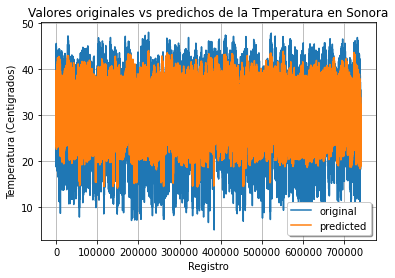

In [46]:
plt.plot(x_ax, y_orig, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Valores originales vs predichos de la Tmperatura en Sonora")
plt.xlabel('Registro')
plt.ylabel('Temperatura (Centigrados)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()